In [2]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%reload_ext autoreload
%autoreload 2
%aimport bs_eda

In [30]:
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import bs_eda as beda
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder

## Liste des modifications

1. Pour les variables `mileage` et `price`, convertir les int64 en float64
1. Supprimer les entrées redondantes
1. `price`:
    * Vérifier les valeurs anormales *Z-score*
    * Log pour normaliser la distribution
1. `year`:
    * Supprimer les années excentriques
    * vérifier les voitures avant 2000
1. `mileage`:
    * Traiter la précense d'anomalies dans les valeurs hautes
    * idem valeurs basses
1. `mpg`:
    * Vérifier la validité des valeurs extrêmes, trop basses et trop hautes.
    * Créer une échelle discrète de rendement: bas, moyen, haut
1. `engine_size`
    * Corriger ou supprimer les valeurs 0
    * traiter les valeurs de 6
    * Créer une échelle discrète de taille de moteur: small, large
    * Utiliser un OrdinalEncoder?
1. `tax`
    * Les données apparaissent difficilement fiables, la feature pourrait être supprimée.
1. Variable discrète
    * Encoder les features. LabelEncoder et/ou OneHotEncoder?
1. `transmission`
    * Supprimer les entrées pour lesquelles le mode de transmission est `Other`
1. `fuel_type`
    * Fusionner ou supprimer les catégories de `fuel_type` qui ne sont pas représentatives
1. `model`
    * LabelEncoder

In [11]:
df = pd.read_csv('dataset/train_set.csv', index_col=0)

In [12]:
# Supprimer les entrées redondantes
df.drop_duplicates(inplace = True)

In [13]:
# Pour les variables `mileage` et `price`, convertir les int64 en float64
df['price'] = df['price'].astype(float)
df['mileage'] = df['mileage'].astype(float)

In [14]:
# Vérifier les valeurs anormales *Z-score*
# Log pour normaliser la distribution
columns = beda.get_numerical_columns(df)
thresh = 3
# mask of all rows whose value > thresh
outliers = df[columns].apply(lambda x: np.abs(zscore(x, nan_policy = 'omit')) > thresh).any(axis=1)
# Drop (inplace) rows that match
df.drop(df[columns].index[outliers], inplace = True)

<AxesSubplot:xlabel='fuel_economy', ylabel='count'>

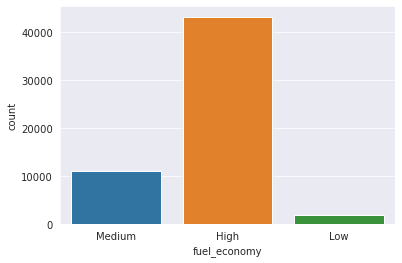

In [19]:
# Créer une échelle discrète de rendement: bas, moyen, haut
def fuel_economy(mpg):
    average = (36,47)
    if mpg<=average[0]: 
        result = "Low"
    if (mpg>average[0] and mpg<average[1]): 
        result = "Medium"
    if mpg>=average[1]: 
        result = "High"
    return result

df["fuel_economy"]=df.apply(lambda x: fuel_economy(x["mpg"]),axis=1)
sns.countplot(data=df,x="fuel_economy")

<AxesSubplot:xlabel='engine_class', ylabel='count'>

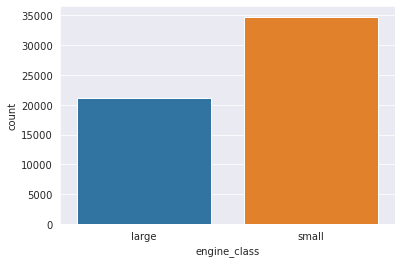

In [21]:
# Créer une échelle discrète de taille de moteur: small, high
def get_engine_class(engine_size):
    if engine_size<2.:
        result = 'small'
    else:
        result = 'large'
    return result

df["engine_class"]=df.apply(lambda x: get_engine_class(x["engine_size"]),axis=1)
sns.countplot(data=df,x="engine_class")

In [ ]:
# suppression de `tax`

In [ ]:
# `transmission`
# Supprimer les entrées pour lesquelles le mode de transmission est `Other`

In [23]:
df = df[df['transmission']!='Other']

In [32]:
# `fuel_type`
# Fusionner ou supprimer les catégories de `fuel_type` qui ne sont pas représentatives
df = df[(df['fuel_type']!='Other')]
df = df[(df['fuel_type']!='Electric')]

In [33]:
df.describe()

,year,price,mileage,tax,mpg,engine_size
count,55836.000000,55836.000000,55836.000000,55836.000000,55836.000000,55836.000000
mean,2017.187191,16179.621785,21898.817967,118.221757,55.011931,1.627626
std,1.754859,7842.495035,17827.555381,59.131393,10.861358,0.494175
min,2011.000000,2395.000000,1.000000,0.000000,8.800000,0.000000
25%,2016.000000,10200.000000,7885.000000,125.000000,47.100000,1.200000
50%,2017.000000,14450.000000,17550.500000,145.000000,55.400000,1.500000
75%,2019.000000,20149.000000,31656.250000,145.000000,62.800000,2.000000
max,2020.000000,46549.000000,86735.000000,305.000000,94.100000,3.000000


## Generate CSV

In [34]:
directory = 'dataset/'
df.to_csv(join(directory,'train_set_preprocessed.csv'))